In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
from shapely.geometry import mapping

# Historical Heatwaves Incidence

In this notebook, we will explore heatwaves incidence, based on [pre-calculated data](ttps://worldbankgroup.sharepoint.com.mcas.ms/teams/DevelopmentDataPartnershipCommunity-WBGroup/Shared%20Documents/Forms/AllItems.aspx?csf=1&web=1&e=Yvwh8r&cid=fccdf23e%2D94d5%2D48bf%2Db75d%2D0af291138bde&FolderCTID=0x012000CFAB9FF0F938A64EBB297E7E16BDFCFD&id=%2Fteams%2FDevelopmentDataPartnershipCommunity%2DWBGroup%2FShared%20Documents%2FProjects%2FHeatwaves%20Data%20Collaborative%2FData%2Fremotesensing%2Fhwdi%5F5degC&viewid=80cdadb3%2D8bb3%2D47ae%2D8b18%2Dc1dd89c373c5) obtained from NASA's [GLDAS](https://ldas.gsfc.nasa.gov/gldas) and NASA's [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.e2161bac?tab=overview)

## Getting multiple datasets that calculate heatwaves based on different definitions

In [2]:
# parallel ensures that it being parallel processing
#ds_mean3 = xr.open_mfßdataset("../../data/gldas/ymean3/wld_cli_*.nc4", parallel=True)
# ds_percentile390 = xr.open_mfdataset("../../data/gldas/ypercentile90/wld_cli_*.nc4", parallel = True)
# ds_mean4= xr.open_mfdataset("../../data/gldas/ymean4/wld_cli_*.nc4", parallel = True)
# ds_percentile490= xr.open_mfdataset("../../data/gldas/ypercentile490/wld_cli_*.nc4", parallel = True)
#ds_mean2_gldas=xr.open_mfdataset("../../data/gldas/ymean2/wld_cli_*.nc4", parallel = True)
ds_mean2_era5 = xr.open_mfdataset('../../data/era5/wld*.nc', parallel=True)
# ds_percentile290=xr.open_mfdataset("../../data/gldas/ypercentile290/wld_cli_*.nc4", parallel = True)

In [55]:
ds_1948 = xr.open_mfdataset('../../data/era5/wld_cli_era5land_tmax_ydrunmean2_hwdi_1981.nc')
ds_2021 = xr.open_mfdataset('../../data/era5/wld_cli_era5land_tmax_ydrunmean2_hwdi_2021.nc')
ds_2016 = xr.open_mfdataset('../../data/era5/wld_cli_era5land_tmax_ydrunmean2_hwdi_2016.nc')

## Change in number of heatwaves from 1948 to 2021

Text(0, 0.5, '# of heatwaves')

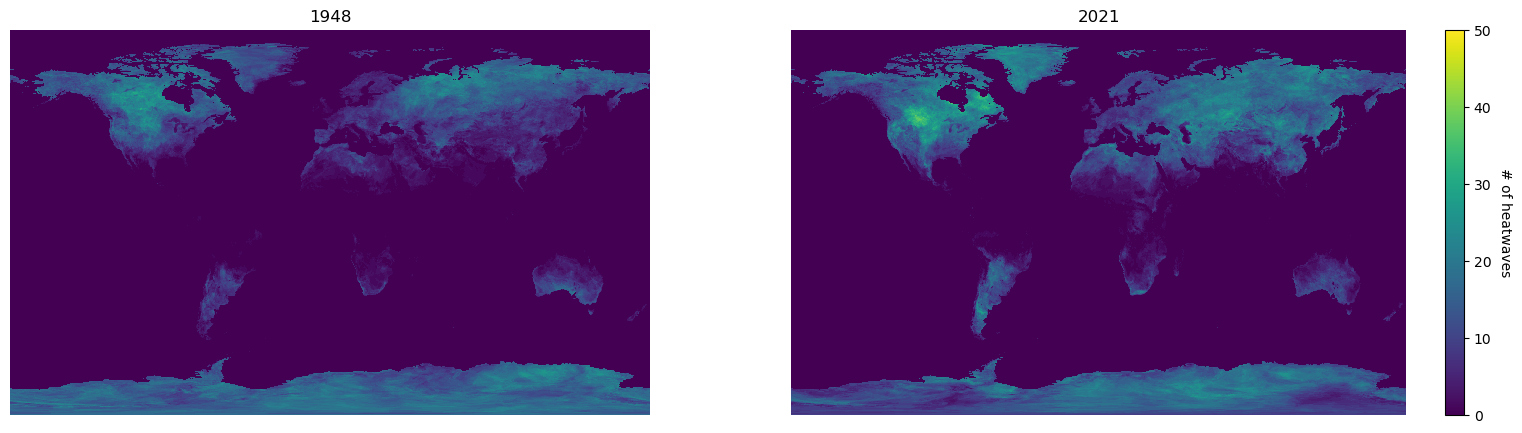

In [4]:
def get_two_year_heatwave_figures(df1, df2):
    fig, ax = plt.subplots(
        1,
        2,
        sharex=True,
        sharey=True,
        figsize=(20, 5),
        gridspec_kw={"width_ratios": [1, 1.2]},
    )

    im = ds_1948["heat_waves_per_time_period"].plot(ax=ax[0], vmin=0, vmax=50)
    im2 = ds_2021["heat_waves_per_time_period"].plot(ax=ax[1], vmin=0, vmax=50)
    # cbar_ax = fig.add_axes([0, 10, 20, 40])
    # fig.colorbar(im, cax=cbar_ax)
    # ax.axis('off')

    ax[0].set_title("1948")
    ax[1].set_title("2021")

    # ax[0].get_legend().remove()

    for i in [0, 1]:
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)
        ax[i].spines["bottom"].set_visible(False)
        ax[i].spines["left"].set_visible(False)
        ax[i].axis("off")

    handles, labels = ax[1].get_legend_handles_labels()
    # print(labels)

    cb = im.colorbar
    cb.remove()

    cb = im2.colorbar
    cb.ax.get_yaxis().labelpad = 15
    cb.ax.set_ylabel("# of heatwaves", rotation=270)

Exploring the data, 

In [ ]:
# time_bnds = [(np.datetime64("1948-01-01"), np.datetime64("2022-04-30"))]
# time_var = ds_tasmax.variables["time"]
# start_date = np.datetime64("2022-02-01")
# end_date = np.datetime64("2022-04-30")

# start_index = np.where(time_var[:] == start_date)[0]
# end_index = np.where(time_var[:] == end_date)[0]

### Boundaries of the region of interest

In this part, we get the shapefiles of the country we're interested in looking at

In [5]:
INDIA = geopandas.read_file("../../data/shapefiles/india_district/sh819zz8121.shp").to_crs("EPSG:4326")
CHENNAI = INDIA[INDIA["laa"] == "CHENNAI"]
DELHI = INDIA[INDIA['laa']=='DELHI']
HYDERABAD = INDIA[INDIA['laa']=='HYDERABAD']
MUMBAI = INDIA[INDIA['laa'].str.contains('MUMBAI')]

In [87]:
PHILIPPINES  = geopandas.read_file('../../data/shapefiles/philippines/phl_adminboundaries_candidate_exclude_adm3/phl_admbnda_adm2_psa_namria_20200529.shp')
MANILA = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin(['NCR, City of Manila, First District', 'NCR, Second District', 'NCR, Third District', 'NCR, Fourth District'])]
CEBU = PHILIPPINES[PHILIPPINES['ADM2_EN'].isin('Cebu')]

type: only list-like objects are allowed to be passed to isin(), you passed a [str]

Taking a quick visual inspection,

## Clipping

In this step, our intention is to clip the heatwaves incident data using boundaries.

In [6]:
import shapely
CHENNAI['geometry'] = CHENNAI['geometry'].apply(lambda x: shapely.wkb.loads(
        shapely.wkb.dumps(x, output_dimension=2)))

/Users/wbdatalab/anaconda3/envs/heatwaves/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [7]:
def clip_area(ds, area):

    ds.rio.write_crs("EPSG:4326", inplace=True)
    clipped_area = ds.rio.clip(area.geometry.values,all_touched=True, drop=True)

    return clipped_area


In [9]:
clipped_hyd = clip_area(ds_mean2_era5, HYDERABAD)
clipped_chennai = clip_area(ds_mean2_era5, CHENNAI)
clipped_delhi = clip_area(ds_mean2_era5, DELHI)
clipped_mumbai = clip_area(ds_mean2_era5, MUMBAI)

Now, converting to a dataframe and `geopandas.GeoDataFrame`

In [33]:
def convert_to_gdf(clipped_area):
    clipped_area = clipped_area.to_dataframe().reset_index()

    # clipped_area = geopandas.GeoDataFrame(
    #     clipped_area, geometry=geopandas.points_from_xy(clipped_area["lon"],clipped_area["lat"])
    # )

    return clipped_area

In [34]:
clipped_hyd = convert_to_gdf(clipped_hyd)
clipped_chennai = convert_to_gdf(clipped_chennai)
clipped_delhi = convert_to_gdf(clipped_delhi)
clipped_mumbai = convert_to_gdf(clipped_mumbai)

In [40]:
clipped_india = clip_area(ds_mean2_era5, INDIA)

In [47]:
clipped_mumbai['heat_waves_per_time_period'].sum()

64.0

In [64]:
clipped_manila = clip_area(ds_mean2_era5, MANILA)

In [67]:
clipped_manila = convert_to_gdf(clipped_manila)#.plot(x='time', y='heat_waves_per_time_period')

Write to file so it can be plotted on foursquare

In [63]:
clipped_india.to_file('../../data/gldas/india_mean2.geojson', driver='GeoJSON')

In [58]:
#clipped_india = clip_area(ds_mean2, INDIA)
clipped_india = convert_to_gdf(clipped_india)

In [71]:
clipped_philippines = clip_area(ds_mean2_era5, PHILIPPINES)

<Axes: xlabel='time'>

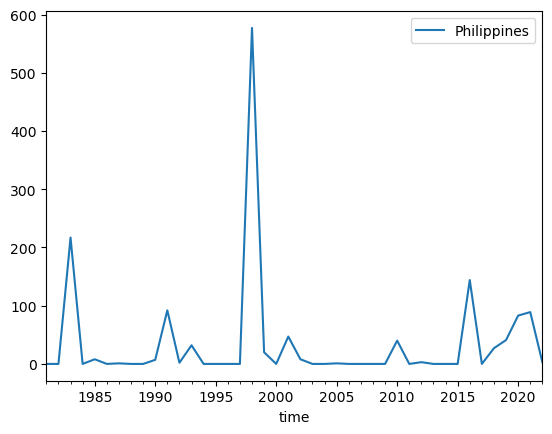

In [77]:
convert_to_gdf(clipped_philippines).groupby([pd.Grouper(key='time', freq='Y')]).sum().reset_index().plot(x='time', y='heat_waves_per_time_period',label = 'Philippines', color = '#1F77B4')

<Axes: xlabel='time'>

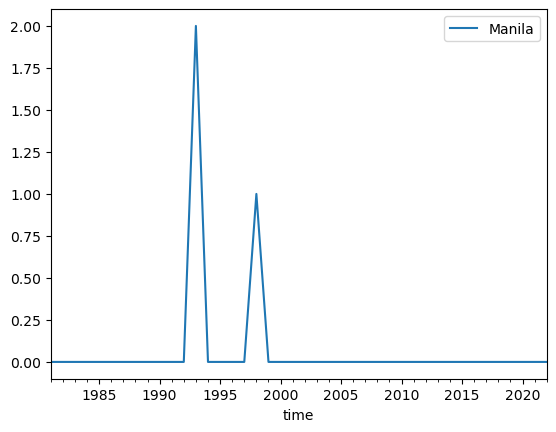

In [78]:
clipped_manila.groupby([pd.Grouper(key='time', freq='Y')]).sum().reset_index().plot(x='time', y='heat_waves_per_time_period',label = 'Manila', color = '#1F77B4')

<Axes: xlabel='time'>

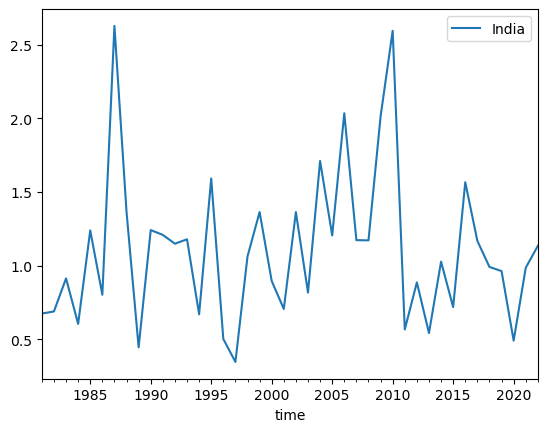

In [62]:
clipped_india.groupby([pd.Grouper(key='time', freq='Y')]).mean().reset_index().plot(x='time', y='heat_waves_per_time_period',label = 'India', color = '#1F77B4')

<Axes: xlabel='time'>

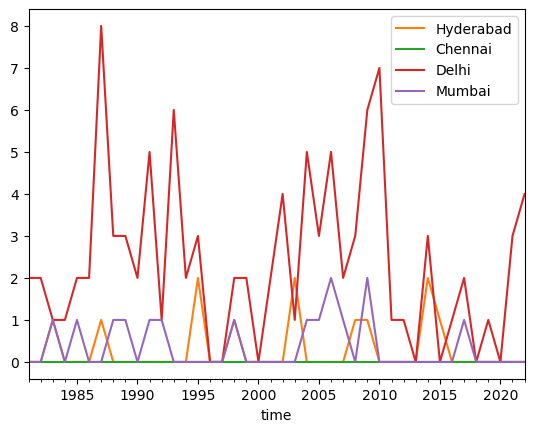

In [54]:
fig, ax = plt.subplots()
#clipped_india.groupby([pd.Grouper(key='time', freq='Y')]).mean().reset_index().plot(x='time', y='heat_waves_per_time_period', ax=ax, label = 'India', color = '#1F77B4')
clipped_hyd.groupby([pd.Grouper(key='time', freq='Y')]).max().reset_index().plot(x='time', y='heat_waves_per_time_period', ax=ax, label = 'Hyderabad', color = '#FF7F0E')
clipped_chennai.groupby([pd.Grouper(key='time', freq='Y')]).max().reset_index().plot(x='time', y='heat_waves_per_time_period', ax=ax, label = 'Chennai', color = '#2CA02C')
clipped_delhi.groupby([pd.Grouper(key='time', freq='Y')]).max().reset_index().plot(x='time', y='heat_waves_per_time_period', ax=ax, label = 'Delhi', color = '#D62728')
clipped_mumbai.groupby([pd.Grouper(key='time', freq='Y')]).max().reset_index().plot(x='time', y='heat_waves_per_time_period', ax=ax, label = 'Mumbai', color = '#9467BD')

## 

In [33]:
df_mean3 = ds_mean3.to_dataframe().groupby(["time", "lat", "lon"]).sum()
df1_mean3 = df_mean3.groupby("time").sum()

## Comparing heatwaves using multiple definitions

<Axes: xlabel='time'>

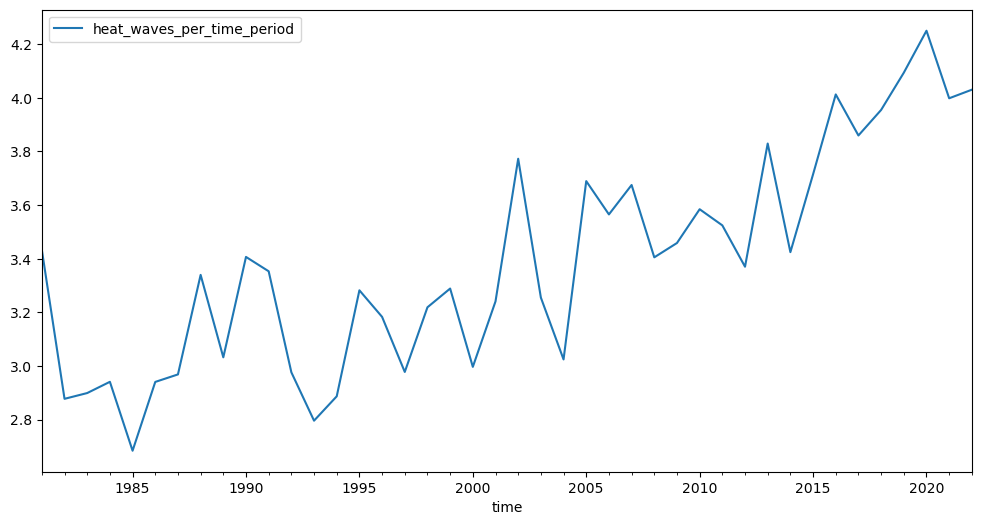

In [82]:
df_mean2 = ds_mean2_era5.to_dataframe().groupby(["time"]).mean()


fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 6))
df_mean2[["heat_waves_per_time_period"]].plot(ax=ax, label="mean2")

In [166]:
df_percentile390 = ds_percentile390.to_dataframe().groupby(["time"]).sum()
df_percentile490 = ds_percentile490.to_dataframe().groupby(["time"]).sum()
df_percentile290 = ds_percentile290.to_dataframe().groupby(["time"]).sum()

df_mean2 = ds_mean2.to_dataframe().groupby(["time"]).sum()

In [169]:
df_mean4 = ds_mean4.to_dataframe().groupby(["time"]).sum()

Text(0.5, 1.0, 'Number of heatwaves using different definitions of a heatwave')

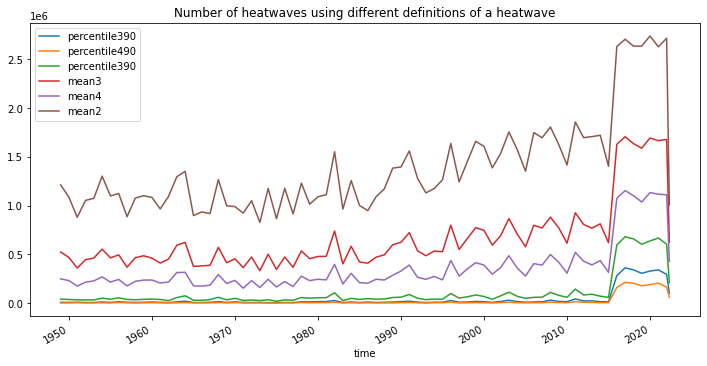

In [177]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(12, 6))
df_percentile390[["heat_waves_per_time_period"]].plot(ax=ax, label="percentile390")
df_percentile490[["heat_waves_per_time_period"]].plot(ax=ax)
df_percentile290[["heat_waves_per_time_period"]].plot(ax=ax)

df_mean3[["heat_waves_per_time_period"]].plot(ax=ax)
df_mean4[["heat_waves_per_time_period"]].plot(ax=ax)
df_mean2[["heat_waves_per_time_period"]].plot(ax=ax)

plt.legend(
    ("percentile390", "percentile490", "percentile390", "mean3", "mean4", "mean2"),
    loc="upper left",
)
plt.title("Number of heatwaves using different definitions of a heatwave")